<a href="https://colab.research.google.com/github/eduardofae/RL/blob/main/AT-07/07%20-%20Model%20based%20RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefa: Implementação e Comparação de Algoritmos de Aprendizado por Reforço Baseado em Modelo

Nesta tarefa, vocês irão implementar e comparar três algoritmos de aprendizado por reforço baseados em modelo: Q-learning, Dyna-Q e Prioritized Sweeping. O objetivo é entender como o uso de um modelo do ambiente pode acelerar o aprendizado e como diferentes abordagens de planejamento (como no Dyna-Q e Prioritized Sweeping) afetam a eficiência do aprendizado.

Vocês trabalharão com dois ambientes simples: um Gridworld 4x3 e um ambiente de Labirinto (Maze), já fornecidos no notebook.

## Parte 1: Implementação dos Agentes

Implemente as classes para os seguintes agentes, herdando da classe base `TDAgent` fornecida:

1.  **`QLearningAgent`**: Já está parcialmente implementado. Complete a lógica de atualização Q-value.
2.  **`DynaQAgent`**: Implemente o agente Dyna-Q, incluindo o aprendizado do modelo e os passos de planejamento.
3.  **`PrioritizedSweepingAgent`**: Implemente o agente Prioritized Sweeping, utilizando uma fila de prioridade para focar o planejamento em transições com maior impacto esperado nos valores Q. Dica: use `heapq` do python.

Certifiquem-se de que cada agente armazena um modelo da transição real observada no ambiente.

## Parte 2: Teste do Modelo (Grid 4x3)

Para verificar se o modelo de transição está sendo aprendido corretamente, vocês irão:

1.  Executar uma sequência específica de ações que leve o agente do estado inicial a um estado terminal (por exemplo, uma sequência que resulta em vitória).
1.  Após a execução desta sequência, inspecionar o modelo aprendido pelos agentes `DynaQAgent` e `PrioritizedSweepingAgent` para garantir que as transições observadas foram corretamente armazenadas. Vocês podem comparar o modelo aprendido com um dicionário esperado contendo as transições dessa sequência.

## Parte 3: Comparação de Desempenho (Maze)

Compare o desempenho dos agentes implementados no ambiente `MazeEnv`. Para isso:

1.  Para cada agente (Q-learning, Dyna-Q e Prioritized Sweeping), execute 30 repetições independentes.
2.  Em cada repetição, treine o agente no ambiente Maze e registre o número total de passos necessários para que o agente atinja 10 episódios de sucesso (episódios onde a recompensa final é positiva). Limite o número máximo de passos por repetição a 1.000.000.
4.  Visualize a distribuição do número de passos para 10 sucessos para cada agente, utilizando um box plot. Assim é possível ver qual agente é mais robusto.

## Análise dos Resultados

Com base nos resultados do experimento da Parte 3, analise (não precisa responder):

*   Qual algoritmo é mais sample-efficient? Uma observação extra interessante é o tempo de relógio. Qual agente executa mais rápido considerando este novo critério?

*   Quais as possíveis vantagens e desvantagens de cada abordagem baseada em modelo neste ambiente específico?





### Grid 4x3

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional,Iterable,Tuple
import matplotlib.pyplot as plt


class GridWorld4x3(gym.Env):
    metadata = {"render_modes": ["ansi"]}

    def __init__(
        self,
        reward_step: float = -0.04,
        slip: float = 0.2,
        max_steps: int = 1000,
        seed: Optional[int] = None,
        render_mode: Optional[str] = None,
    ):
        super().__init__()
        self.ncols = 4
        self.nrows = 3
        self.observation_space = spaces.Discrete(self.ncols * self.nrows)
        self.action_space = spaces.Discrete(4)  # 0=up, 1=right, 2=down, 3=left

        self.reward_step = reward_step
        self.slip = slip
        self.max_steps = max_steps
        self.render_mode = render_mode

        self.start_pos = (0, 0)
        self.goal_pos = (3, 2)  # state 11
        self.pit_pos = (3, 1)   # state 7
        self.wall_pos = (1, 1)  # state 5 (inacessível)

        self._rng = np.random.default_rng(seed)
        self.steps = 0
        self.agent_pos = self.start_pos

        # Movimentos: up, right, down, left
        self.moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    # ---------- conversão estado/posição ----------
    def pos_to_state(self, pos):
        x, y = pos
        return y * self.ncols + x

    def state_to_pos(self, s):
        return (s % self.ncols, s // self.ncols)

    # ---------- helpers internos ----------
    def _move(self, pos, action):
        dx, dy = self.moves[action]
        x, y = pos
        new_pos = (x + dx, y + dy)
        # checa limites e parede
        if not (0 <= new_pos[0] < self.ncols and 0 <= new_pos[1] < self.nrows):
            return pos
        if new_pos == self.wall_pos:
            return pos
        return new_pos

    def _reward_and_done(self, pos):
        if pos == self.goal_pos:
            return 1.0, True
        elif pos == self.pit_pos:
            return -1.0, True
        return self.reward_step, False

    # ---------- API Gym ----------
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.agent_pos = self.start_pos
        self.steps = 0
        return self.pos_to_state(self.agent_pos), {}

    def step(self, action):
        self.steps += 1

        # sorteia se escorrega
        if self._rng.random() < self.slip:
            if action in [0, 2]:  # up/down → troca por left/right
                action = self._rng.choice([1, 3])
            else:  # left/right → troca por up/down
                action = self._rng.choice([0, 2])

        self.agent_pos = self._move(self.agent_pos, action)
        reward, terminated = self._reward_and_done(self.agent_pos)
        truncated = self.steps >= self.max_steps

        return self.pos_to_state(self.agent_pos), reward, terminated, truncated, {}

    # ----------------------------
    # Rendering
    # ----------------------------
    def render(self, mode="ansi"):
        if mode == "ansi":
            return self._render_ansi()
        else:
            raise NotImplementedError

    def _render_ansi(self):
        out = ""
        for y in reversed(range(self.nrows)):
            out += "+----" * self.ncols + "+\n"
            for x in range(self.ncols):
                pos = (x, y)
                s = self.pos_to_state(pos)
                cell = f"{s:2d} "
                if pos == self.wall_pos:
                    cell = " ## "
                elif pos == self.goal_pos:
                    cell = f"{s:2d}G"
                elif pos == self.pit_pos:
                    cell = f"{s:2d}P"
                elif pos == self.start_pos:
                    cell = f"{s:2d}S"
                if self.agent_pos == self.state_to_pos(s):
                    cell = f"[{cell.strip()}]"
                out += f"|{cell:4}"
            out += "|\n"
        out += "+----" * self.ncols + "+\n"
        return out



## Maze

Ambiente como o do livro, Fig. 8.2

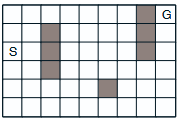

In [ ]:
class MazeEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, step_reward=0.0, max_steps=500):
        super().__init__()
        self.WORLD_WIDTH = 9
        self.WORLD_HEIGHT = 6
        self.n_states = self.WORLD_WIDTH * self.WORLD_HEIGHT

        # ações: UP, DOWN, LEFT, RIGHT
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Discrete(self.n_states)

        self.START_STATE = [2, 0]
        self.GOAL_STATES = [[0, 8]]
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]

        self.state = None
        self.steps = 0
        self.max_steps = max_steps
        self.step_reward = step_reward

    def pos_to_state(self, pos):
        x, y = pos
        return x * self.WORLD_WIDTH + y

    def state_to_pos(self, s):
        return divmod(s, self.WORLD_WIDTH)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.pos_to_state(self.START_STATE)
        self.steps = 0
        return self.state, {}

    def step(self, action):
        x, y = self.state_to_pos(self.state)

        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)

        if [x, y] in self.obstacles:
            x, y = self.state_to_pos(self.state)

        self.state = self.pos_to_state([x, y])
        self.steps += 1

        if [x, y] in self.GOAL_STATES:
            reward = 1.0
            terminated = True
        else:
            reward = self.step_reward
            terminated = False

        truncated = self.steps >= self.max_steps
        return self.state, reward, terminated, truncated, {}

    def render(self, mode="human"):
        grid = np.full((self.WORLD_HEIGHT, self.WORLD_WIDTH), " ")
        for ox, oy in self.obstacles:
            grid[ox, oy] = "#"
        for gx, gy in self.GOAL_STATES:
            grid[gx, gy] = "G"
        x, y = self.state_to_pos(self.state)
        grid[x, y] = "A"
        print("\n".join("".join(row) for row in grid))
        print()


## Código dos agentes

### TDAgent

In [ ]:
from abc import ABC,abstractmethod

class TDAgent(ABC):
    def __init__(self, env: gym.Env, alpha: float = 0.1, gamma: float = 0.99, epsilon: float = 0.1):
        """
        Construtor do agente TD.

        Args:
            env: ambiente Gymnasium (ex: gridworld 4x3).
            alpha: taxa de aprendizado.
            gamma: fator de desconto.
            epsilon: taxa de exploração (para política epsilon-greedy).
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        obs_space_size = env.observation_space.n
        act_space_size = env.action_space.n
        self.q_values = np.zeros((obs_space_size, act_space_size))

    def Q(self, state, action) -> float:
      """Retorna Q(s,a)."""
      return self.q_values[state, action]

    def V(self, state) -> float:
      """Retorna V(s) = max_a Q(s,a)."""
      return np.max(self.q_values[state, :])

    def greedy_action(self, state) -> int:
      """Retorna a ação gulosa (argmax_a Q(s,a))."""
      return np.argmax(self.q_values[state, :])

    def act(self, state) -> int:
      """Retorna ação epsilon-greedy."""
      if np.random.rand() < self.epsilon:
          return self.env.action_space.sample()
      else:
          return self.greedy_action(state)

### Q-Learning

In [ ]:
class QLearningAgent(TDAgent):
    def updateQ(self, s, a, r, s_next, done: bool):
        """Atualiza Q(s,a) segundo a regra do Q-Learning."""
        self.q_values[s,a] += self.alpha * (r + self.gamma * self.V(s_next) - self.Q(s,a))


### Dyna-Q

In [ ]:
import random
class DynaQAgent(TDAgent):
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=10):
        super().__init__(env, alpha, gamma, epsilon)
        self.planning_steps = planning_steps
        self.model = {}  # (s,a) -> (r, s', done)

    def plan(self):
        for _ in range(self.planning_steps):
            S, A = random.choice(list(self.model.keys()))
            R, S_next, Done = self.model[S,A]
            self.q_values[S,A] += self.alpha * (R + self.gamma * self.V(S_next) - self.Q(S,A))

    def updateQ(self, s, a, r, s_next, done: bool):
        self.q_values[s,a] += self.alpha * (r + self.gamma * self.V(s_next) - self.Q(s,a))
        self.model[s,a] = (r, s_next, done)
        self.plan()


### Prioritized Sweeping

In [ ]:
import heapq

class PrioritizedSweepingAgent(TDAgent):
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=10, theta=1e-4):
        super().__init__(env, alpha, gamma, epsilon)
        self.planning_steps = planning_steps
        self.theta = theta  # threshold for adding to priority queue
        self.model = {}  # (s,a) -> (r, s_next, done)
        self.preds = {}
        self.pq = []

    def add_to_queue(self, s, a, r, s_next, done):
        priority = abs(r + self.gamma * self.V(s_next) - self.Q(s,a))
        if priority >= self.theta:
            heapq.heappush(self.pq, (-priority, (s,a)))

    def add_prevs(self, s):
        if s not in self.preds: return
        for S_prev, A_prev in self.preds[s]:
            R, _, Done = self.model[S_prev, A_prev]
            self.add_to_queue(S_prev, A_prev, R, s, Done)

    def plan(self):
        for _ in range(self.planning_steps):
            if not self.pq: break
            _, (S, A) = heapq.heappop(self.pq)
            R, S_next, Done = self.model[S,A]
            self.q_values[S,A] += self.alpha * (R + self.gamma * self.V(S_next) - self.Q(S,A))
            self.add_prevs(S)

    def updateQ(self, s, a, r, s_next, done: bool):
        self.model[s,a] = (r, s_next, done)
        if s_next not in self.preds: self.preds[s_next] = set()
        self.preds[s_next].add((s, a))
        self.add_to_queue(s, a, r, s_next, done)
        self.plan()


## Visualizador do agente

### Para o Grid 4x3

In [ ]:
class Grid4x3AgentVisualizer:
    def __init__(self, agent, env):
        """
        agent: ValueIterationAgent-like (tem V(s), Q(s,a) e greedy_action(s))
        env: GridWorld4x3-like (tem nrows, ncols, pos_to_state, state_to_pos, is_terminal, get_states, start_pos, goal_pos, pit_pos, wall_pos)
        """
        self.agent = agent
        self.env = env
        self.action_to_str = {0: "↑", 1: "→", 2: "↓", 3: "←"}

        # Precompute special states
        self.wall_s = self.env.pos_to_state(self.env.wall_pos)
        self.start_s = self.env.pos_to_state(self.env.start_pos)
        self.goal_s = self.env.pos_to_state(self.env.goal_pos)
        self.pit_s = self.env.pos_to_state(self.env.pit_pos)

    # -----------------------
    # Política (setas)
    # -----------------------
    def print_policy(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "##"
                elif s == self.goal_s:
                    content = " G "
                elif s == self.pit_s:
                    content = " P "
                else:
                    a = self.agent.greedy_action(s)
                    arrow = self.action_to_str.get(a, "?")
                    if s == self.start_s:
                        content = f"S{arrow}"
                    else:
                        content = arrow
                cells.append(f"{content:^6}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Valores V(s)
    # -----------------------
    def print_values(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["--------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "####"
                else:
                    v = self.agent.V(s)
                    if s == self.goal_s:
                        content = f"G({v:.2f})"
                    elif s == self.pit_s:
                        content = f"P({v:.2f})"
                    else:
                        content = f"{v:6.2f}"
                cells.append(f"{content:^8}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Q-values
    # -----------------------
    def print_qvalues(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["---------------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            # três linhas por célula
            line1, line2, line3 = [], [], []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    c1 = "###############"
                    c2 = "###############"
                    c3 = "###############"
                else:
                    qvals = [self.agent.Q(s, a) for a in range(4)]
                    best = int(np.argmax(qvals))
                    up = f"↑:{qvals[0]:.2f}"
                    left = f"←:{qvals[3]:.2f}"
                    right = f"→:{qvals[1]:.2f}"
                    down = f"↓:{qvals[2]:.2f}"
                    c1 = f"{up:^15}"
                    c2 = f"{left:<7}{right:>8}"
                    c3 = f"{down:^15}"
                line1.append(c1)
                line2.append(c2)
                line3.append(c3)

            # agora cada linha recebe delimitadores
            print("|" + "|".join(line1) + "|")
            print("|" + "|".join(line2) + "|")
            print("|" + "|".join(line3) + "|")
        print(horiz)


### Para o Maze

In [ ]:
class MazeAgentVisualizer:
    def __init__(self, agent, env):
        """
        agent: objeto que implementa V(s), Q(s,a), greedy_action(s)
        env: MazeEnv (tem WORLD_HEIGHT, WORLD_WIDTH, START_STATE, GOAL_STATES, obstacles)
        """
        self.agent = agent
        self.env = env

        # dimensões
        self.nrows = self.env.WORLD_HEIGHT
        self.ncols = self.env.WORLD_WIDTH

        # estados especiais
        self.start_s = self.pos_to_state(tuple(self.env.START_STATE))
        self.goal_s = [self.pos_to_state(tuple(g)) for g in self.env.GOAL_STATES]
        self.wall_s = [self.pos_to_state(tuple(w)) for w in self.env.obstacles]

        # mapeamento de ações
        self.action_to_str = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    # -----------------------
    # Helpers
    # -----------------------
    def pos_to_state(self, pos):
        x, y = pos
        return x * self.ncols + y

    def state_to_pos(self, s):
        return divmod(s, self.ncols)

    # -----------------------
    # Política (setas)
    # -----------------------
    def print_policy(self):
        horiz = "+" + "+".join(["------"] * self.ncols) + "+"

        # x=0 topo, x=HEIGHT-1 base
        for x in range(self.nrows):
            print(horiz)
            cells = []
            for y in range(self.ncols):
                s = self.pos_to_state((x, y))
                if s in self.wall_s:
                    content = "##"
                elif s in self.goal_s:
                    content = " G "
                else:
                    a = self.agent.greedy_action(s)
                    arrow = self.action_to_str.get(a, "?")
                    content = f"S{arrow}" if s == self.start_s else arrow
                cells.append(f"{content:^6}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Valores V(s)
    # -----------------------
    def print_values(self):
        horiz = "+" + "+".join(["--------"] * self.ncols) + "+"

        for x in range(self.nrows):
            print(horiz)
            cells = []
            for y in range(self.ncols):
                s = self.pos_to_state((x, y))
                if s in self.wall_s:
                    content = "####"
                else:
                    v = self.agent.V(s)
                    if s in self.goal_s:
                        content = f"G({v:.2f})"
                    else:
                        content = f"{v:6.2f}"
                cells.append(f"{content:^8}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Q-values
    # -----------------------
    def print_qvalues(self):
        horiz = "+" + "+".join(["---------------"] * self.ncols) + "+"

        for x in range(self.nrows):
            print(horiz)
            line1, line2, line3 = [], [], []
            for y in range(self.ncols):
                s = self.pos_to_state((x, y))
                if s in self.wall_s:
                    c1 = c2 = c3 = "###############"
                else:
                    qvals = [self.agent.Q(s, a) for a in range(4)]
                    up    = f"↑:{qvals[0]:.2f}"
                    down  = f"↓:{qvals[1]:.2f}"
                    left  = f"←:{qvals[2]:.2f}"
                    right = f"→:{qvals[3]:.2f}"
                    c1 = f"{up:^15}"
                    c2 = f"{left:<7}{right:>8}"
                    c3 = f"{down:^15}"
                line1.append(c1)
                line2.append(c2)
                line3.append(c3)
            print("|" + "|".join(line1) + "|")
            print("|" + "|".join(line2) + "|")
            print("|" + "|".join(line3) + "|")
        print(horiz)


## Executando os agentes



### Teste 1: Teste do Modelo (Grid 4x3)

Este teste verifica se os agentes Dyna-Q e Prioritized Sweeping estão armazenando corretamente as transições do ambiente em seus modelos após a execução de uma sequência de ações pré-definida no ambiente Grid 4x3 sem escorregamento e com recompensa de passo zero.

**Sequência de ações:** `simple_episode_win = [0, 0, 1, 1, 1]` (up, up, right, right, right), levando o agente do estado inicial (0,0) ao estado objetivo (3,2).

**Resultado esperado:** O modelo aprendido deve conter as seguintes transições observadas:
*   `((0, 0), 0)` -> `(0, (0, 1), False)`
*   `((0, 1), 0)` -> `(0, (0, 2), False)`
*   `((0, 2), 1)` -> `(0, (1, 2), False)`
*   `((1, 2), 1)` -> `(0, (2, 2), False)`
*   `((2, 2), 1)` -> `(1, (3, 2), True)`


In [ ]:
# Test Dyna-Q and Prioritized Sweeping model storage with a simple episode

simple_episode_win = [0, 0, 1, 1, 1] #up, up, right, right, right

env_test = GridWorld4x3(slip=0, reward_step=0)

# Initialize agents with planning steps set to 0 to only observe model updates from real transitions
dyna_q_test_agent = DynaQAgent(env_test, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=0)
ps_test_agent = PrioritizedSweepingAgent(env_test, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=0)

# Define the expected model
expected_model = { #((x,y), action) -> ((r, next_x, next_y), done)
    ((0, 0), 0): (0, (0, 1), False),
    ((0, 1), 0): (0, (0, 2), False),
    ((0, 2), 1): (0, (1, 2), False),
    ((1, 2), 1): (0, (2, 2), False),
    ((2, 2), 1): (1, (3, 2), True)
}


state, _ = env_test.reset()

# Run the simple episode for Dyna-Q
print("Running simple episode for Dyna-Q agent...")
for action in simple_episode_win:
    next_state, reward, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated
    # Update Q-value and model based on real transition
    dyna_q_test_agent.updateQ(state, action, reward, next_state, done)
    state = next_state
    if done:
        break # Stop if episode finishes

# Convert state-action tuples to readable format (pos, action)
readable_model_dyna_q = {}
for (s, a), (r, s_next, done_sim) in dyna_q_test_agent.model.items():
    pos = env_test.state_to_pos(s)
    next_pos = env_test.state_to_pos(s_next)
    readable_model_dyna_q[(pos, a)] = (r, next_pos, done_sim)

# Compare the actual model with the expected model
print("Comparing Dyna-Q model with expected:")
if readable_model_dyna_q == expected_model:
    print("Dyna-Q model matches the expected model.")
else:
    print("Dyna-Q model does NOT match the expected model.")
    print("Actual model:", readable_model_dyna_q)
    print("Expected model:", expected_model)


# Reset environment and run the simple episode for Prioritized Sweeping
print("\nRunning simple episode for Prioritized Sweeping agent...")
state, _ = env_test.reset()
for action in simple_episode_win:
    next_state, reward, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated
    # Update Q-value and model based on real transition
    ps_test_agent.updateQ(state, action, reward, next_state, done)
    state = next_state
    if done:
        break # Stop if episode finishes

readable_model_ps = {}
for (s, a), (r, s_next, done_sim) in ps_test_agent.model.items():
    pos = env_test.state_to_pos(s)
    next_pos = env_test.state_to_pos(s_next)
    readable_model_ps[(pos, a)] = (r, next_pos, done_sim)


# Compare the actual model with the expected model
print("Comparing PS model with expected:")
if readable_model_ps == expected_model:
    print("PS model matches the expected model.")
else:
    print("PS model does NOT match the expected model.")
    print("Actual model:", readable_model_ps)
    print("Expected model:", expected_model)

Running simple episode for Dyna-Q agent...
Comparing Dyna-Q model with expected:
Dyna-Q model matches the expected model.

Running simple episode for Prioritized Sweeping agent...
Comparing PS model with expected:
PS model matches the expected model.


## Comparação no MazeEnv
Compare o desempenho dos agentes implementados no ambiente `MazeEnv`. Para isso:

1.  Para cada agente (Q-learning, Dyna-Q e Prioritized Sweeping), execute 30 repetições independentes.
2.  Em cada repetição, treine o agente no ambiente Maze e registre o número total de passos necessários para que o agente atinja 10 episódios de sucesso (episódios onde a recompensa final é positiva). Limite o número máximo de passos por repetição a 1.000.000.
4.  Visualize a distribuição do número de passos para 10 sucessos para cada agente, utilizando um box plot. Assim é possível ver qual agente é mais robusto.

In [ ]:
from tqdm.notebook import tnrange
N_REPETITIONS = 30
N_STEPS = 1_000_000

env = MazeEnv(step_reward=-0.01, max_steps=N_STEPS)
steps = {'QL': [], 'Dyna-Q': [], 'PS': []}

def train(agent_class, agent_name, n_steps=N_STEPS):
    state, _ = env.reset()
    agent = agent_class(env)
    num_success = 0
    for step in range(n_steps):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        succeded = terminated and reward > 0
        agent.updateQ(state, action, reward, next_state, done)
        state = next_state
        if succeded:
            num_success += 1
            if num_success == 10:
                steps[agent_name].append(step)
                return
        if done:
            state, _ = env.reset()
    steps.append(N_STEPS)

for _ in tnrange(N_REPETITIONS, desc='Repetitions'):
    train(QLearningAgent, 'QL')
    train(DynaQAgent, 'Dyna-Q')
    train(PrioritizedSweepingAgent, 'PS')

Repetitions:   0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipython-input-3232029878.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(steps.values(), labels=steps.keys())


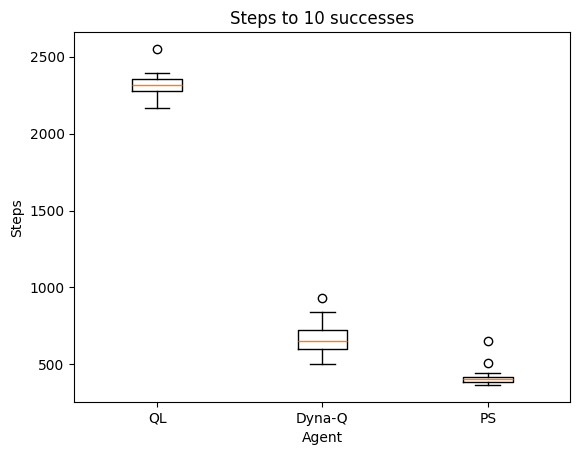

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the box plot
fig, ax = plt.subplots()
ax.boxplot(steps.values(), labels=steps.keys())

# Add titles and labels (optional)
ax.set_title('Steps to 10 successes')
ax.set_xlabel('Agent')
ax.set_ylabel('Steps')

plt.show()